In [315]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import swiper.plot as plotter
from typing import Any
import scipy
import pandas as pd

In [316]:
# directory = 'slurm/data/benchmarks'
# directory = 'slurm/data/20241112_150658'
# directory = 'slurm/data/20241113_124552'
# directory = 'slurm/data/20241114_113627'
# directory = 'slurm/data/20241115_113558'
directories = ['slurm/data/20241115_170539', 'slurm/data/20241116_113228']
directories = ['slurm/data/20241118_215925', 'slurm/data/20241119_135256']
exclude_benchmarks = [['toffoli'], []]

In [317]:
config = []
config_idx_offset = 0
data_by_config = {}
for i,directory in enumerate(directories):
    with open(f'{directory}/config.json', 'r') as f:
        dir_config = json.load(f)
    config.extend(dir_config)
    for file in os.listdir(f'{directory}/output/'):
        print(file)
        with open(f'{directory}/output/{file}', 'r') as f:
            contents = f.read()
            if len(contents) == 0:
                print('Empty file!')
                continue
            data = json.loads(contents)
        config_idx = int(file.split('_')[0][6:])
        if config[config_idx + config_idx_offset]['benchmark_file'].split('/')[-1].split('.')[0] in exclude_benchmarks[i]:
            continue
        data_by_config[config_idx + config_idx_offset] = data
    config_idx_offset = len(config)

# directory = 'slurm/data/20241115_143108'
# with open(f'{directory}/config.json', 'r') as f:
#     config_unlimited = json.load(f)
# data_by_config_unlimited = {}
# for file in os.listdir(f'{directory}/output/'):
#     print(file)
#     with open(f'{directory}/output/{file}', 'r') as f:
#         contents = f.read()
#         if len(contents) == 0:
#             print('Empty file!')
#             continue
#         data = json.loads(contents)
#     config_idx = int(file.split('_')[0][6:])
#     data_by_config_unlimited[config_idx] = data

config600_d21_parallel_separate_rz_1e-20_6.json
config500_d21_parallel_separate_carleman_2_4_3.json
config590_d21_parallel_separate_adder_n4_5.json
config461_d21_parallel_separate_rz_1e-05_2.json
config35_d21_sliding_separate_rz_seq_10_0.json
config181_d21_sliding_separate_msd_15to1_4.json
config944_d21_aligned_separate_qrom_15_15_5.json
config433_d21_parallel_separate_qpeinexact_5_1.json
config413_d21_parallel_separate_adder_n4_0.json
config558_d21_parallel_separate_toffoli_4.json
config555_d21_parallel_separate_adder_n18_4.json
config1088_d21_aligned_separate_qpeinexact_5_9.json
config902_d21_aligned_separate_adder_n10_4.json
config787_d21_aligned_separate_adder_n28_0.json
config101_d21_sliding_separate_qpeinexact_5_2.json
config1062_d21_aligned_separate_adder_n28_8.json
config1095_d21_aligned_separate_qpeexact_5_9.json
config683_d21_parallel_separate_msd_15to1_8.json
config1178_d21_parallel_None_qrom_15_15_3.json
config708_d21_parallel_separate_adder_n18_9.json
config1020_d21_aligne

In [318]:
def benchmark_name(conf):
    return conf['benchmark_file'].split('/')[-1].split('.')[0]

def get_config_idx(config, schedule_name, config_match):
    indices = []
    for idx, conf in enumerate(config):
        if benchmark_name(conf) == schedule_name and all(conf[k] == v for k, v in config_match.items()):
            indices.append(idx)
    if len(indices) == 1:
        return indices[0]
    else:
        print(f'Found {len(indices)} matches for {schedule_name} and {config_match}: {indices}')
    return None

def get_data(config, data_by_config, schedule_name, config_match):
    config_idx = get_config_idx(config, schedule_name, config_match)
    if config_idx is None:
        return None
    return data_by_config[config_idx]

In [319]:
sliding_data = get_data(config, data_by_config, 'carleman_encoding_2_4', {'scheduling_method':'sliding', 'speculation_mode':'separate', 'distance':21})

Found 0 matches for carleman_encoding_2_4 and {'scheduling_method': 'sliding', 'speculation_mode': 'separate', 'distance': 21}: []


In [320]:
get_config_idx(config, 'toffoli', {'scheduling_method':'parallel', 'speculation_mode':None, 'max_parallel_processes':None}), get_config_idx(config, 'regular_t_1000_0', {'scheduling_method':'sliding', 'speculation_accuracy': 0.99})

Found 20 matches for toffoli and {'scheduling_method': 'parallel', 'speculation_mode': None, 'max_parallel_processes': None}: [1120, 1141, 1158, 1175, 1192, 1209, 1226, 1243, 1260, 1277, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533]
Found 0 matches for regular_t_1000_0 and {'scheduling_method': 'sliding', 'speculation_accuracy': 0.99}: []


(None, None)

In [321]:
get_config_idx(config, 'toffoli', {'scheduling_method':'parallel', 'speculation_mode':None, 'max_parallel_processes':None})

Found 20 matches for toffoli and {'scheduling_method': 'parallel', 'speculation_mode': None, 'max_parallel_processes': None}: [1120, 1141, 1158, 1175, 1192, 1209, 1226, 1243, 1260, 1277, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533]


In [322]:
hatches = ['', '//', '/////', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [330]:
def to_str(key_name, key_val):
    if key_name == 'scheduling_method':
        return key_val
    elif key_name == 'speculation_mode':
        return 'SWIPER' if key_val else 'Default'
    elif key_name == 'benchmark':
        return key_val
    else:
        raise NotImplementedError(f'Unknown key name {key_name}')  

from matplotlib.colors import LinearSegmentedColormap

colors = ['C1', 'C0']
cmaps = [LinearSegmentedColormap.from_list('cmap0', ['white', colors[0]]), LinearSegmentedColormap.from_list('cmap1', ['white', colors[1]])]
def plot_data(
        data_by_config,
        config,
        group_by: str,
        group_by_2: str,
        filter_dict: dict[str, Any] = {},
        relative_to: dict[str, Any] | None = None,
        compare_data = None,
        compare_config = None,
        sorted_keys: list[str] = [],
        sorted_keys_2: list[str] = [],
        sorted_benchmarks: list[str] = [],
        custom_plot_val: tuple[str, str] = ('device_data', 'num_rounds'),
        x_offsets_after: dict[str, float] = {},
        modifiers: dict[str, Any] = {},
        ax = None,
        hidden_benchmarks: list[str] = [],
    ):
    benchmarks = []
    group_keys = []
    group_keys_2 = []
    results = {}
    limited_proc_results = {}
    for key, data in data_by_config.items():
        if not all(config[key][k] == v for k, v in filter_dict.items()):
            continue
        if not data['success']:
            continue
        benchmark = benchmark_name(config[key])
        runtime = data[custom_plot_val[0]][custom_plot_val[1]]
        group_key = config[key][group_by]
        group_key_2 = config[key][group_by_2]
        benchmarks.append(benchmark)
        group_keys.append(group_key)
        group_keys_2.append(group_key_2)

        if data['simulator_params']['max_parallel_processes'] is None:
            results.setdefault((benchmark, group_key, group_key_2), []).append(runtime)  
        else:
            # limited processors
            limited_proc_results.setdefault((benchmark, group_key, group_key_2), []).append(runtime)
        
    # if compare_data:
    #     for key, data in compare_data.items():
    #         if not all(compare_config[key][k] == v for k, v in filter_dict.items()):
    #             continue
    #         if not data['success']:
    #             continue
    #         benchmark = benchmark_name(compare_config[key])
    #         runtime = data[custom_plot_val[0]][custom_plot_val[1]]
    #         group_key = compare_config[key][group_by]
    #         group_key_2 = compare_config[key][group_by_2]
    #         benchmarks.append(benchmark)
    #         group_keys.append(group_key)
    #         group_keys_2.append(group_key_2)

    # Remove those that do not have all data
    expected_num_data = len(set((k,k2) for b,k,k2 in results.keys()))
    for benchmark in set(benchmarks) | set(sorted_benchmarks):
        if len(set((k,k2) for b,k,k2 in results.keys() if b == benchmark)) != expected_num_data:
            print(f'Removing {benchmark} (only {len(set((k,k2) for b,k,k2 in results.keys() if b == benchmark))} data points)')
            benchmarks = [b for b in benchmarks if b != benchmark]
            results = {k:v for k,v in results.items() if k[0] != benchmark}
            if benchmark in sorted_benchmarks:
                sorted_benchmarks = [b for b in sorted_benchmarks if b != benchmark]

    result_means = {}
    result_stdevs = {}
    for key in results.keys():
        result_means[key] = np.mean(results[key])
        result_stdevs[key] = np.std(results[key])
    limited_proc_result_means = {}
    limited_proc_result_stdevs = {}
    for key in limited_proc_results.keys():
        limited_proc_result_means[key] = np.mean(limited_proc_results[key])
        limited_proc_result_stdevs[key] = np.std(limited_proc_results[key])

    # sort benchmarks and group keys by average 
    if len(sorted_benchmarks) < len(set(benchmarks)):
        benchmark_avgs = {b:np.mean([r for (bench,_,_),r in result_means.items() if bench == b]) for b in set(benchmarks) if b not in sorted_benchmarks}
        sorted_benchmarks = sorted_benchmarks + sorted(benchmark_avgs, key=lambda k: benchmark_avgs[k])
    sorted_benchmarks = [x for x in sorted_benchmarks if not (x.startswith('memory') or x.startswith('random') or x.startswith('regular') or (x.startswith('rz') and x != 'rz_1e-10'))]
    sorted_benchmarks = [x for x in sorted_benchmarks if x not in hidden_benchmarks]
    if len(sorted_keys) < len(set(group_keys)):
        print(1)
        key_avgs = {k:np.mean([r for (_,key,_),r in result_means.items() if key == k]) for k in set(group_keys)}
        sorted_keys = sorted(key_avgs, key=lambda x: key_avgs[x], reverse=True)
    if len(sorted_keys_2) < len(set(group_keys_2)):
        print(2)
        key_2_avgs = {k:np.mean([r for (_,_,key),r in result_means.items() if key == k]) for k in set(group_keys_2)}
        sorted_keys_2 = sorted(key_2_avgs, key=lambda x: key_2_avgs[x], reverse=True)

    colors_by_keys = {key:{key2:cmaps[j]((len(sorted_keys_2)-k)/(len(sorted_keys_2))) for k,key2 in enumerate(sorted_keys_2)} for j,key in enumerate(sorted_keys)}

    limited_proc_val_differences = []

    if ax is None:
        fig,ax = plt.subplots(figsize=(9,2))
        
    x_offset = 0
    centers = []
    for i,benchmark in enumerate(sorted_benchmarks):
        center = i*(len(sorted_keys)+len(sorted_keys_2)+2) + (len(sorted_keys)+len(sorted_keys_2))/2 + x_offset + 1/2
        centers.append(center)
        prev_x = i*(len(sorted_keys)+len(sorted_keys_2)+2) + x_offset
        for j,key in enumerate(sorted_keys):
            for k,key_2 in enumerate(sorted_keys_2):
                failed = False
                try:
                    prev_x += 1
                    relative_to_val = result_means[(benchmark, relative_to[group_by], relative_to[group_by_2])] if relative_to is not None else 1
                    result_val = result_means[(benchmark,key,key_2)] / relative_to_val * modifiers.get(benchmark, 1)
                    result_stdev_val = result_stdevs[(benchmark,key,key_2)] / relative_to_val * modifiers.get(benchmark, 1)
                    mpl.rcParams['hatch.linewidth'] = 1.0
                    ax.bar(prev_x, result_val, yerr=result_stdev_val, color=colors_by_keys[key][key_2], width=1, hatch=hatches[k], label=f'{to_str(group_by, key)} {to_str(group_by_2, key_2)}' if i == 0 else None, zorder=5)
                except KeyError as e:
                    failed = True
                    prev_x -= 1
                if not failed and (benchmark,key,key_2) in limited_proc_results and result_stdevs[(benchmark,key,key_2)] > 0:
                    limited_proc_val_differences += [(result - result_means[(benchmark,key,key_2)]) / result_means[(benchmark,key,key_2)] for i,result in enumerate(limited_proc_results[(benchmark,key,key_2)]) if results[(benchmark,key,key_2)][i] > 10**4]
        x_offset += x_offsets_after.get(benchmark, 0)
    ax.set_xticks(centers, sorted_benchmarks, rotation=20, ha='right', fontsize=9)
    # ax.set_xlim(-1, prev_x+1)
    ax.tick_params(direction='in')

    return ax, result_means, result_stdevs, limited_proc_result_means, limited_proc_result_stdevs, sorted_benchmarks, sorted_keys, sorted_keys_2, colors_by_keys, limited_proc_val_differences

In [331]:
benchmark_info = pd.read_csv('benchmarks/benchmark_info.csv', index_col=0)
benchmark_info['density'] = benchmark_info['Ideal volume'] / (benchmark_info['Space footprint'] * benchmark_info['Ideal time'])
benchmarks_sorted_by_volume = benchmark_info.sort_values('T count').index

Removing qft_10 (only 2 data points)
Removing grover_ancilla_5 (only 2 data points)
Removing memory_1000 (only 0 data points)
Removing random_t_10000_200_0 (only 0 data points)
Removing qpeexact_20 (only 0 data points)
Removing regular_t_1000_0 (only 0 data points)
Removing heisenberg_3 (only 0 data points)
Removing qpeexact_10 (only 3 data points)
Removing random_t_1000_200_0 (only 0 data points)
Removing memory_10000 (only 0 data points)
Removing qft_30 (only 0 data points)
Removing qft_20 (only 0 data points)
Removing electronic_structure (only 0 data points)
Removing heisenberg_5 (only 0 data points)
Removing grover_ancilla_9 (only 0 data points)
1
2
Removing qft_10 (only 2 data points)
Removing grover_ancilla_5 (only 2 data points)
Removing qpeexact_10 (only 3 data points)
1
2


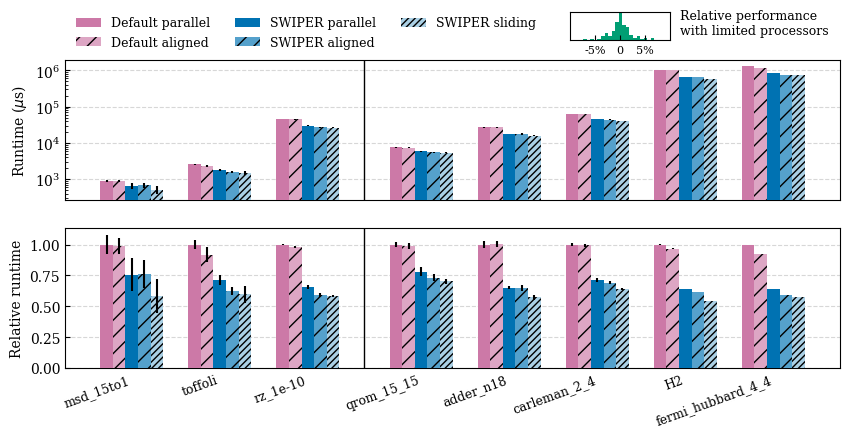

In [335]:
fig,ax = plt.subplots(2,1, figsize=(10,4), sharex=True)

microbench = ['msd_15to1', 'toffoli', 'rz_1e-10']
hidden_benchmarks = ['adder_n4', 'adder_n10', 'adder_n28', 'qpeinexact_5', 'qpeexact_5', 'fermi_hubbard_2_2', 'qpeinexact_10']

_, result_means, result_stdevs, limited_proc_result_means, limited_proc_result_stdevs, sorted_benchmarks, sorted_keys, sorted_keys_2, colors_by_keys, limited_proc_val_differences = plot_data(
    data_by_config,
    config,
    'speculation_mode',
    'scheduling_method',
    relative_to={'scheduling_method':'parallel', 'speculation_mode':None},
    sorted_benchmarks=microbench + [b for b in benchmarks_sorted_by_volume if b not in microbench],
    x_offsets_after={
        'rz_1e-10':2.0,
    },
    ax=ax[1],
    hidden_benchmarks=hidden_benchmarks,
)
ax[1].set_ylabel('Relative runtime', fontsize=10)
ax[1].axvline(21.5, color='k', linewidth=1)

handles, labels = ax[1].get_legend_handles_labels()
order = [0,1,2,3,4]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower left', bbox_to_anchor=(0, 1.0), ncol=3, fontsize=9, edgecolor='black', frameon=False)

ax_inset = ax[0].figure.add_axes([0.63, 0.93, 0.1, 0.07])
ax_inset.hist(limited_proc_val_differences, bins=20, color='C2')
ax_inset.tick_params(direction='in', which='both')
ax_inset.set_xlim(-0.1, 0.1)
ax_inset.set_xticks([-0.05, 0, 0.05], ['-5%', '0', '5%'], fontsize=8)
ax_inset.set_yticks([])

ax[1].grid(axis='y', linestyle='--', alpha=0.5, zorder=-10)
ax[0].grid(axis='y', linestyle='--', alpha=0.5, zorder=-10)

ax[0].text(0.74, 0.945, 'Relative performance\nwith limited processors', transform=fig.transFigure, fontsize=9)

_, _, _, _, _, _, _, _, _, _ = plot_data(
    data_by_config,
    config,
    'speculation_mode',
    'scheduling_method',
    sorted_benchmarks=sorted_benchmarks,
    x_offsets_after={
        'rz_1e-10':2.0,
    },
    ax=ax[0],
    hidden_benchmarks=hidden_benchmarks,
)

ax[0].set_ylabel(r'Runtime ($\mu$s)', fontsize=10)
ax[0].axvline(21.5, color='k', linewidth=1)
ax[0].tick_params(direction='in', which='both')
ax[0].set_yscale('log')
plt.savefig('notebooks/figures/benchmarks_combined.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/benchmarks_combined.svg', bbox_inches='tight')
plt.show()

In [329]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

improvements_aligned = []
improvements_swiper_parallel = []
improvements_swiper_aligned = []
improvements_swiper_sliding = []
for benchmark in sorted_benchmarks:
    improvements_aligned.append(1 - result_means[(benchmark, None, 'aligned')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_parallel.append(1 - result_means[(benchmark, 'separate', 'parallel')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_aligned.append(1 - result_means[(benchmark, 'separate', 'aligned')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_sliding.append(1 - result_means[(benchmark, 'separate', 'sliding')] / result_means[(benchmark, None, 'parallel')])

print(f'Improvements aligned: {min(improvements_aligned)*100:0.1f}% to {max(improvements_aligned)*100:0.1f}% (geometric mean {geo_mean(improvements_aligned)*100:0.1f}%)')
print(f'Improvements SWIPER parallel: {min(improvements_swiper_parallel)*100:0.1f}% to {max(improvements_swiper_parallel)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_parallel)*100:0.1f}%)')
print(f'Improvements SWIPER aligned: {min(improvements_swiper_aligned)*100:0.1f}% to {max(improvements_swiper_aligned)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_aligned)*100:0.1f}%)')
print(f'Improvements SWIPER sliding: {min(improvements_swiper_sliding)*100:0.1f}% to {max(improvements_swiper_sliding)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_sliding)*100:0.1f}%)')

Improvements aligned: -0.3% to 8.1% (geometric mean nan%)
Improvements SWIPER parallel: 21.9% to 36.1% (geometric mean 30.1%)
Improvements SWIPER aligned: 23.8% to 40.8% (geometric mean 33.7%)
Improvements SWIPER sliding: 29.8% to 45.7% (geometric mean 39.7%)


/var/folders/vy/pypq_bm52_50g15jqc51yyr80000gp/T/ipykernel_2102/2483784267.py:3: RuntimeWarning: invalid value encountered in scalar power
  return a.prod()**(1.0/len(a))


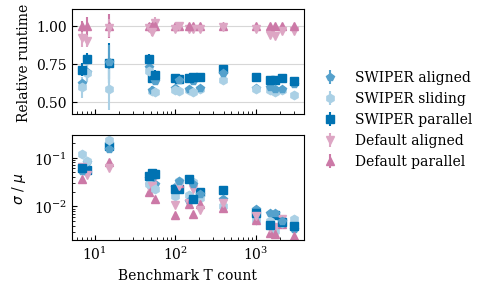

In [305]:
fig,ax = plt.subplots(2,1,figsize=(3,3), sharex=True)
markers = {
    None: {
        'parallel': '^',
        'aligned': 'v'
    },
    'separate': {
        'parallel': 's',
        'aligned': 'p',
        'sliding': 'h',
    }
}
made_labels = {key:{key2:False for key2 in set([k for _,_,k in result_means.keys() if _ == key])} for key in set([k for _,k,_ in result_means.keys()])}
for key,mean in result_means.items():
    stdev = result_stdevs[key]
    if stdev == 0:
        continue
    t_count = benchmark_info.loc[key[0], 'T count']
    relative_to = result_means[(key[0], None, 'parallel')]
    ax[0].errorbar(t_count, mean / relative_to, yerr=stdev / relative_to, marker=markers[key[1]][key[2]], linestyle='none', color=colors_by_keys[key[1]][key[2]], label=f'{to_str("speculation_mode", key[1])} {to_str("scheduling_method", key[2])}' if not made_labels[key[1]][key[2]] else None)
    made_labels[key[1]][key[2]] = True
# ax[0].loglog()
handles, labels = ax[0].get_legend_handles_labels()
order = [1,2,0,4,3]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center left', bbox_to_anchor=(1.0, -0.05), fontsize=10, frameon=False)
# ax[0].set_xlabel('T count')
ax[0].grid(axis='y', alpha=0.5, zorder=-10)
ax[0].set_ylabel('Relative runtime')
ax[0].tick_params(direction='in', which='both')

made_labels = {key:{key2:False for key2 in set([k for _,_,k in result_means.keys() if _ == key])} for key in set([k for _,k,_ in result_means.keys()])}
for key,mean in result_means.items():
    stdev = result_stdevs[key]
    if stdev == 0:
        continue
    t_count = benchmark_info.loc[key[0], 'T count']
    ax[1].errorbar(t_count, stdev / mean, marker=markers[key[1]][key[2]], linestyle='none', color=colors_by_keys[key[1]][key[2]], label=f'{to_str("speculation_mode", key[1])} {to_str("scheduling_method", key[2])}' if not made_labels[key[1]][key[2]] else None)
    made_labels[key[1]][key[2]] = True
ax[1].loglog()
# handles, labels = ax[1].get_legend_handles_labels()
# order = [1,2,0,4,3]
# ax[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10, frameon=False)
ax[1].set_xlabel('Benchmark T count')
ax[1].set_ylabel(r'$\sigma$ / $\mu$')
ax[1].tick_params(direction='in', which='both')
plt.savefig('notebooks/figures/tcount_vs_stdev.pdf', bbox_inches='tight')
plt.show()

In [271]:
benchmark_info['t density'] = benchmark_info['T count'] / benchmark_info['Instruction count']

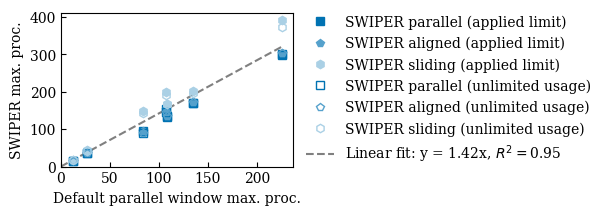

In [272]:
fig,ax = plt.subplots(figsize=(3,2))

parallel_procs = {}
for key, data in data_by_config.items():
    if not data['success']:
        continue
    benchmark = benchmark_name(config[key])
    procs = data['decoding_data']['max_parallel_processes']
    group_key = config[key]['speculation_mode']
    group_key_2 = config[key]['scheduling_method']
    if ('grover_ancilla_5', 'separate', 'parallel') == (benchmark, group_key, group_key_2):
        print(config[key]['max_parallel_processes'])
    if config[key]['max_parallel_processes'] is None:
        # unlimited
        parallel_procs.setdefault((benchmark, group_key, group_key_2, False), []).append(data['decoding_data']['max_parallel_processes'])
    else:
        parallel_procs.setdefault((benchmark, group_key, group_key_2, True), []).append(data['simulator_params']['max_parallel_processes'])

xs = []
ys = [[], [], [], [], [], []]

for i,benchmark in enumerate(sorted_benchmarks):
    init_len = len(xs)
    try:
        xs.append(np.mean(parallel_procs[(benchmark, None, 'parallel', False)]))
        ys[0].append(np.mean(parallel_procs[(benchmark, 'separate', 'parallel', True)]))
        ys[1].append(np.mean(parallel_procs[(benchmark, 'separate', 'aligned', True)]))
        ys[2].append(np.mean(parallel_procs[(benchmark, 'separate', 'sliding', True)]))
        ys[3].append(np.mean(parallel_procs[(benchmark, 'separate', 'parallel', False)]))
        ys[4].append(np.mean(parallel_procs[(benchmark, 'separate', 'aligned', False)]))
        ys[5].append(np.mean(parallel_procs[(benchmark, 'separate', 'sliding', False)]))
    except:
        xs = xs[:init_len]
        ys = [y[:init_len] for y in ys]

# for i,benchmark in enumerate(sorted_benchmarks):
ax.plot(xs, ys[0], marker=markers['separate']['parallel'], linestyle='none', color=colors_by_keys['separate']['parallel'], label=f'SWIPER parallel (applied limit)')
ax.plot(xs, ys[1], marker=markers['separate']['aligned'], linestyle='none', color=colors_by_keys['separate']['aligned'], label=f'SWIPER aligned (applied limit)')
ax.plot(xs, ys[2], marker=markers['separate']['sliding'], linestyle='none', color=colors_by_keys['separate']['sliding'], label=f'SWIPER sliding (applied limit)')
ax.plot(xs, ys[3], marker=markers['separate']['parallel'], linestyle='none', markerfacecolor='none', color=colors_by_keys['separate']['parallel'], markeredgewidth=1, label=f'SWIPER parallel (unlimited usage)')
ax.plot(xs, ys[4], marker=markers['separate']['aligned'], linestyle='none', markerfacecolor='none', color=colors_by_keys['separate']['aligned'], markeredgewidth=1, label=f'SWIPER aligned (unlimited usage)')
ax.plot(xs, ys[5], marker=markers['separate']['sliding'], linestyle='none', markerfacecolor='none', color=colors_by_keys['separate']['sliding'], markeredgewidth=1, label=f'SWIPER sliding (unlimited usage)')

all_data = np.hstack(ys)
all_xs = np.hstack([xs for y in ys])
def fixed_line(x, slope):
    return slope*x
result = scipy.optimize.curve_fit(fixed_line, all_xs, all_data)
r2 = 1 - np.sum((all_data - fixed_line(all_xs, *result[0]))**2) / np.sum((all_data - np.mean(all_data))**2)
ax.plot([0, max(xs)], [0, max(xs)*result[0][0]], color='gray', linestyle='--', label=f'Linear fit: y = {result[0][0]:0.2f}x' + r', $R^2=$' + f'{r2:0.2f}', zorder=-1)

# ax.plot(xs, np.array(ys[0])+10+np.random.random()*5, marker=markers['separate']['parallel'], linestyle='none', color=colors_by_keys['separate']['parallel'], label=f'SWIPER parallel')
# ax.plot(xs, np.array(ys[1])+10+np.random.random()*5, marker=markers['separate']['aligned'], linestyle='none', color=colors_by_keys['separate']['aligned'], label=f'SWIPER aligned')
# ax.plot(xs, np.array(ys[2])+10+np.random.random()*5, marker=markers['separate']['sliding'], linestyle='none', color=colors_by_keys['separate']['sliding'], label=f'SWIPER sliding')
ax.set_xlim(0)
ax.set_ylim(0)
# ax.loglog()
# ax.set_title('Max. parallel processes')
ax.set_xlabel('Default parallel window max. proc.')
ax.set_ylabel('SWIPER max. proc.')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10, frameon=False)
ax.tick_params(direction='in', which='both')
plt.savefig('notebooks/figures/max_parallel_processes.pdf', bbox_inches='tight')
plt.show()